In [1]:
import cv2
import numpy as np
import pandas as pd
import tensorflow as tf
import pathlib
from tensorflow import keras
from keras.models import Model
import matplotlib.pyplot as plt
from keras.optimizers import Adam
import tensorflow_datasets as tfds
from sklearn.decomposition import PCA
from keras.losses import MeanSquaredError, BinaryCrossentropy
from keras.layers import Input, Conv2D, UpSampling2D, MaxPooling2D, PReLU

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [4]:
filename_dataset = tf.data.Dataset.list_files("/kaggle/input/hardfakevsrealfaces/real/*.jpg")

# Make a Dataset of image tensors by reading and decoding the files.
image_dataset = filename_dataset.map(lambda x: tf.io.decode_jpeg(tf.io.read_file(x)))
image_dataset = image_dataset.map(lambda image: tf.image.resize(image,(256,256),method = tf.image.ResizeMethod.NEAREST_NEIGHBOR))

ds = image_dataset.cache() # Cashing the data
ds = ds.batch(8) # Batching it into 32 images
ds = ds.prefetch(4)


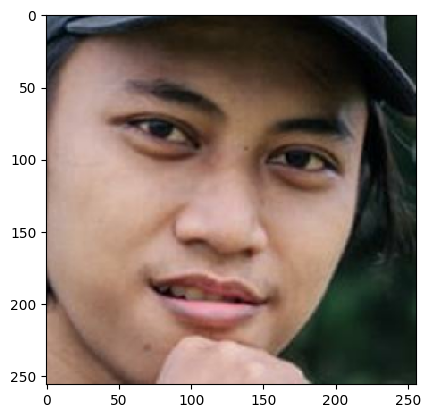

In [5]:
image = ds.as_numpy_iterator().next()
plt.imshow(image[0])

In [6]:
print(f"No of images,x,y,z {ds.as_numpy_iterator().next().shape}")

No of images,x,y,z (8, 256, 256, 3)


**Auto-Encoder**

In [7]:
INPUT = Input((256,256,3))
CONV1 = Conv2D(256,3,activation = 'relu',name = 'CONV1',padding = 'same')(INPUT)
MAXPOOL1 = MaxPooling2D()(CONV1)
CONV2 = Conv2D(128,3,activation = 'relu',name = 'CONV2',padding = 'same')(MAXPOOL1)
MAXPOOL2 = MaxPooling2D()(CONV2)
CONV3 = Conv2D(64,3,activation = 'relu', name ='CONV3',padding = 'same')(MAXPOOL2)
MAXPOOL3 = MaxPooling2D()(CONV3)
DECODER_INPUT = Conv2D(32,3,activation = 'relu',name = 'DECODER_INPUT',padding = 'same')(MAXPOOL3)

UPSAMPLE1 = UpSampling2D((2,2))(DECODER_INPUT)
UCONV1 = Conv2D(32,3,activation = 'relu',name = 'UCONV1',padding = 'same')(UPSAMPLE1)
UPSAMPLE2 = UpSampling2D((2,2))(UCONV1)
UCONV2 = Conv2D(64,3,activation = 'relu', name ='UCONV2',padding = 'same')(UPSAMPLE2)
UPSAMPLE3 = UpSampling2D((2,2))(UCONV2)
UCONV3 = Conv2D(128,3,activation = 'relu', name ='UCONV3',padding = 'same')(UPSAMPLE3)
OUTPUT = Conv2D(3,3,activation = 'relu',padding = 'same',name = 'OUTPUT')(UCONV3)

In [13]:
model = Model(inputs = [INPUT],outputs = [OUTPUT])

**Training**

In [14]:
optimizer = Adam(0.001,beta_1 = 0.5)
lossobj = MeanSquaredError()

In [15]:
def loss(model, x, y, training):
    y_ = model(x,training = training)
    return lossobj(y_true = y, y_pred = y_)

In [16]:
def grad(model,inputs,outputs):
    with tf.GradientTape() as tape:
        loss_value = loss(model,inputs,outputs,training = True)
    return loss_value, tape.gradient(loss_value, model.trainable_variables)

In [17]:
def train():
    train_loss = []
    train_metrics = []

    EPOCHS = 50

    for epoch in range(EPOCHS):
        epoch_loss_avg = tf.keras.metrics.Mean()
        epoch_metric = tf.keras.metrics.MeanSquaredError()
    
        for i in ds:
            x,y = i,i
            loss_value, grads = grad(model,x,y)
            optimizer.apply_gradients(zip(grads,model.trainable_variables))
        
            epoch_loss_avg.update_state(loss_value)
        
            epoch_metric.update_state(y,model(x,training = True))
        
        train_loss.append(epoch_loss_avg.result())
        train_metrics.append(epoch_metric.result())
    
        if epoch % 1 == 0:
            print("Epoch {:03d}: Loss: {:.3f}, Mean Squared Error: {:.3}".format(epoch,
                                                                epoch_loss_avg.result(),
                                                                epoch_metric.result()))
    fig, axes = plt.subplots(2, sharex=True, figsize=(12, 8))
    fig.suptitle('Training Metrics')

    axes[0].set_ylabel("Loss", fontsize=14)
    axes[0].plot(train_loss)

    axes[1].set_ylabel("MSE", fontsize=14)
    axes[1].set_xlabel("Epoch", fontsize=14)
    axes[1].plot(train_metrics)
    plt.show()

Epoch 000: Loss: 2618.516, Mean Squared Error: 2.4e+03
Epoch 001: Loss: 1887.836, Mean Squared Error: 1.98e+03
Epoch 002: Loss: 1787.438, Mean Squared Error: 1.69e+03
Epoch 003: Loss: 643.099, Mean Squared Error: 6.28e+02
Epoch 004: Loss: 454.527, Mean Squared Error: 4.58e+02
Epoch 005: Loss: 358.631, Mean Squared Error: 3.66e+02
Epoch 006: Loss: 382.986, Mean Squared Error: 3.81e+02
Epoch 007: Loss: 299.942, Mean Squared Error: 3.02e+02
Epoch 008: Loss: 613.659, Mean Squared Error: 6.56e+02
Epoch 009: Loss: 48383.012, Mean Squared Error: 5.05e+04
Epoch 010: Loss: 8831.445, Mean Squared Error: 8.81e+03
Epoch 011: Loss: 7539.100, Mean Squared Error: 7.53e+03
Epoch 012: Loss: 7306.896, Mean Squared Error: 7.3e+03
Epoch 013: Loss: 7265.506, Mean Squared Error: 7.26e+03
Epoch 014: Loss: 7345.533, Mean Squared Error: 7.35e+03
Epoch 015: Loss: 7312.514, Mean Squared Error: 7.3e+03
Epoch 016: Loss: 7281.229, Mean Squared Error: 7.27e+03
Epoch 017: Loss: 7256.980, Mean Squared Error: 7.25e+03


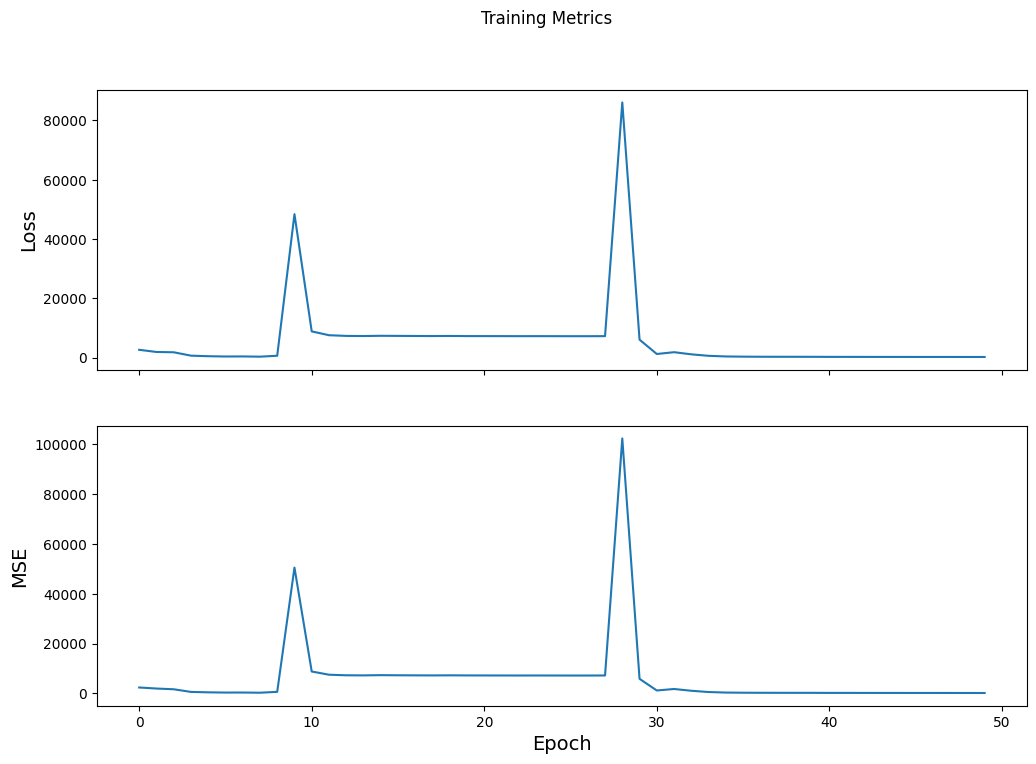

In [18]:
with tf.device(':/GPU:0'):
    train()

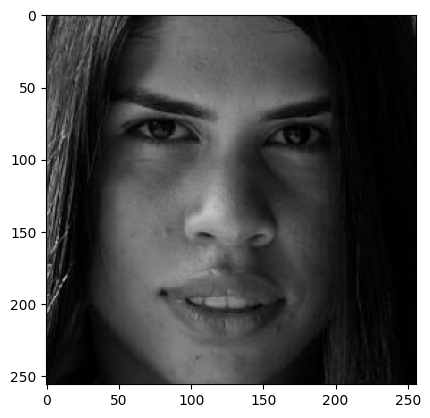

In [19]:
img = tf.io.read_file(r'/kaggle/input/hardfakevsrealfaces/real/real_1.jpg')
img = tf.io.decode_jpeg(img,channels = 3)
img = tf.image.resize(img,(256,256),method = tf.image.ResizeMethod.NEAREST_NEIGHBOR)
#img = cv2.resize(img,(256,256))

plt.imshow(img)

In [20]:
img = np.expand_dims(img,axis=0)
output = model(img)

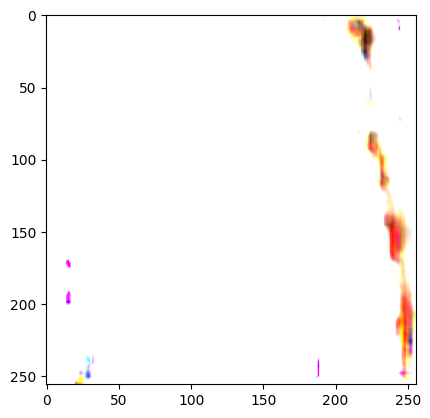

In [21]:
plt.imshow(np.squeeze(output))

1/1 [==============================] - 0s 370ms/step


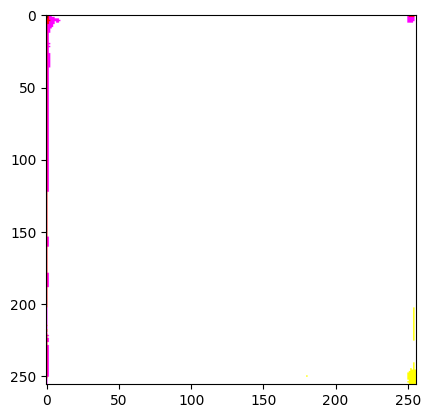

In [22]:
output = model.predict(img)
plt.imshow(np.squeeze(output))